# Plot scan

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../plotting')
from auxPlots import interpolateData, getContours
import seaborn as sns
from scipy.interpolate import interp1d
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

### Load ATLAS Curve

In [25]:
atlasCurve = np.genfromtxt('./ATLAS_data/HEPData-ins2080541-v1-csv/MassLimitvs.Lifetime,R-hadron,compressed,Observed.csv',skip_header=9,delimiter=',')

### Load Recast Data

In [57]:
recastDF_all = pd.read_pickle('./gluinoRecast.pcl')
recastDF_all['robs'] = 1/recastDF_all['$\mu_{obs}$']

### Get all model points

In [59]:
mLLP = 'mLLP'
mn1= 'mLSP'
tau = 'tau_ns'
models = []
mCols = [mLLP,mn1,tau,'robs']
recastDF_all.sort_values(mCols,inplace=True,ascending=True)
recastDF = recastDF_all.drop_duplicates(subset=[mLLP,mn1,tau],keep="last")

for row in recastDF[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
print('%i models loaded' %len(models))

63 models loaded


### Get K-factors

In [77]:
gluinoNLO = np.genfromtxt('./xsecs_gluino.csv',delimiter=',',names=True)
xsecF = interp1d(gluinoNLO['Gluino_mass_GeV'],gluinoNLO['Cross_section_pb'],bounds_error=False,fill_value='extrapolate')
recastDF['kfactor'] = recastDF[mLLP].apply(xsecF)/recastDF['Total xsec (pb)']

### Plot exclusion for each analysis

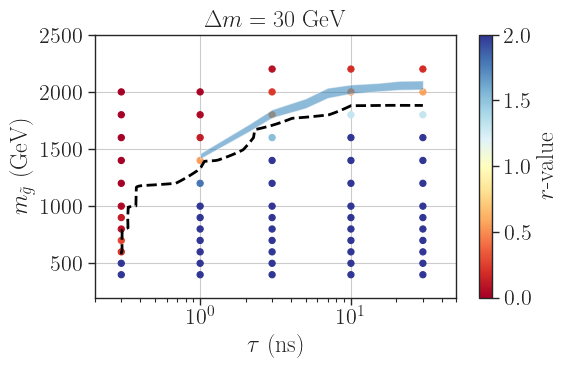

In [79]:
fig = plt.figure(figsize=(6,4))
y = recastDF['mLLP']
x = recastDF['tau_ns']
rValues = recastDF['robs']*recastDF['kfactor']
p = plt.scatter(x=x,y=y,vmin=0.0,vmax=2.0,
        c=rValues,cmap=cm,s=20)
plt.colorbar(label=r'$r$-value')
# Interpolate to create more points
xnew,ynew,znew = interpolateData(x,y,rValues,nx=500,ny=500)
cValues = sorted([1.])
# Get contours
plt.contour(xnew, ynew, znew, cValues, 
                           colors='black',linestyles='dashed',
                           linewidths=2.0)
# plt.plot(atlasCurve[:,0],atlasCurve[:,1],label='ATLAS')
plt.fill_between(atlasCurve[:,0],atlasCurve[:,1]+atlasCurve[:,2],atlasCurve[:,1]+atlasCurve[:,3],
                 label='ATLAS',alpha=0.5)

plt.ylabel(r'$m_{\tilde g}$ (GeV)')
plt.xlabel(r'$\tau$ (ns)')
plt.xscale('log')
plt.xlim(0.2,50.)
plt.ylim(200.,2500.)
# ax.set_ylim(5.0,1.1*y.max())
plt.grid()

# fig.subplots_adjust(right=0.9,top=1.1)
# cbar_ax = fig.add_axes([0.99, 0.25, 0.01, 0.5]) 
# plt.legend()
plt.title(r'$\Delta m = 30$ GeV')
plt.tight_layout()
plt.show()